# Import libraries

In [38]:

import pandasql as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from pyspark.sql import SparkSession
from datetime import datetime as dt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
usd_php_forex_4hour_df = pd.read_csv("./include/data/usd_php_forex_4hour.csv", index_col=0)
usd_php_forex_4hour_df

,v,vw,o,c,h,l,t,n
0,183,54.5591,54.464,54.577,54.616,54.464,1681084800000,183
1,431,54.5877,54.576,54.618,54.641,54.390,1681099200000,431
2,538,54.6423,54.616,54.663,54.687,54.471,1681113600000,538
3,498,54.6885,54.643,54.754,54.787,54.390,1681128000000,498
4,124,54.7292,54.764,54.690,54.777,54.666,1681142400000,124
...,...,...,...,...,...,...,...,...
2791,785,57.9079,57.996,57.868,58.163,56.303,1735632000000,785
2792,1106,57.9427,57.858,57.782,58.123,57.745,1735646400000,1106
2793,1156,57.9018,57.782,58.181,58.181,57.774,1735660800000,1156
2794,1,58.1810,58.181,58.181,58.181,58.181,1735675200000,1


In [40]:
usd_php_forex_4hour_df.dtypes

v       int64
vw    float64
o     float64
c     float64
h     float64
l     float64
t       int64
n       int64
dtype: object

In [41]:
usd_php_forex_4hour_df['t'] / 1000

0       1.681085e+09
1       1.681099e+09
2       1.681114e+09
3       1.681128e+09
4       1.681142e+09
            ...     
2791    1.735632e+09
2792    1.735646e+09
2793    1.735661e+09
2794    1.735675e+09
2795    1.735762e+09
Name: t, Length: 2796, dtype: float64

In [42]:
usd_php_forex_4hour_df.rename(columns={'v': "volume", 'vw': "volume_weighted", 'o': "opening_price", 'c': "closing_price", 'h': "highest_price", 'l': "lowest_price", 't': "timestamp", 'n': "transactions"}, inplace=True)
usd_php_forex_4hour_df["timestamp"] = usd_php_forex_4hour_df["timestamp"].apply(lambda timestamp: dt.fromtimestamp(timestamp / 1000))

In [43]:
usd_php_forex_4hour_df

,volume,volume_weighted,opening_price,closing_price,highest_price,lowest_price,timestamp,transactions
0,183,54.5591,54.464,54.577,54.616,54.464,2023-04-10 08:00:00,183
1,431,54.5877,54.576,54.618,54.641,54.390,2023-04-10 12:00:00,431
2,538,54.6423,54.616,54.663,54.687,54.471,2023-04-10 16:00:00,538
3,498,54.6885,54.643,54.754,54.787,54.390,2023-04-10 20:00:00,498
4,124,54.7292,54.764,54.690,54.777,54.666,2023-04-11 00:00:00,124
...,...,...,...,...,...,...,...,...
2791,785,57.9079,57.996,57.868,58.163,56.303,2024-12-31 16:00:00,785
2792,1106,57.9427,57.858,57.782,58.123,57.745,2024-12-31 20:00:00,1106
2793,1156,57.9018,57.782,58.181,58.181,57.774,2025-01-01 00:00:00,1156
2794,1,58.1810,58.181,58.181,58.181,58.181,2025-01-01 04:00:00,1


In [44]:
usd_php_forex_4hour_df_stats = usd_php_forex_4hour_df.describe()
usd_php_forex_4hour_df_stats

,volume,volume_weighted,opening_price,closing_price,highest_price,lowest_price,timestamp,transactions
count,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2796,2796.000000
mean,680.018956,56.678219,56.675024,56.664925,56.767058,56.321917,2024-02-18 06:30:28.326180352,680.018956
min,1.000000,54.250000,51.267000,46.082000,54.250000,46.040000,2023-04-10 08:00:00,1.000000
25%,221.750000,55.792775,55.792750,55.785000,55.883500,55.515750,2023-09-12 03:00:00,221.750000
50%,602.000000,56.361550,56.370500,56.364500,56.464000,56.130000,2024-02-19 14:00:00,602.000000
75%,964.000000,57.684650,57.694000,57.688500,57.800000,57.362250,2024-07-25 17:00:00,964.000000
max,12884.000000,59.137200,59.355000,59.376000,59.378000,58.925000,2025-01-02 04:00:00,12884.000000
std,597.233623,1.175251,1.187561,1.236505,1.178822,1.444448,NaN,597.233623


In [45]:
usd_php_forex_4hour_df_stats.loc["min", "timestamp"]

Timestamp('2023-04-10 08:00:00')

In [46]:
x_ticks = pd.date_range(start=usd_php_forex_4hour_df_stats.loc["min", "timestamp"], end=usd_php_forex_4hour_df_stats.loc["max", "timestamp"], periods=usd_php_forex_4hour_df.shape[0])
x_ticks

DatetimeIndex([          '2023-04-10 08:00:00',
               '2023-04-10 13:26:02.361359570',
               '2023-04-10 18:52:04.722719141',
               '2023-04-11 00:18:07.084078711',
               '2023-04-11 05:44:09.445438282',
               '2023-04-11 11:10:11.806797853',
               '2023-04-11 16:36:14.168157423',
               '2023-04-11 22:02:16.529516994',
               '2023-04-12 03:28:18.890876565',
               '2023-04-12 08:54:21.252236135',
               ...
               '2024-12-31 03:05:38.747763856',
               '2024-12-31 08:31:41.109123432',
                  '2024-12-31 13:57:43.470483',
               '2024-12-31 19:23:45.831842568',
               '2025-01-01 00:49:48.193202144',
               '2025-01-01 06:15:50.554561712',
               '2025-01-01 11:41:52.915921280',
               '2025-01-01 17:07:55.277280856',
               '2025-01-01 22:33:57.638640424',
                         '2025-01-02 04:00:00'],
              dtype=

In [47]:
start_date = 'january 1 2024'
end_date = 'january 1 2025'

In [48]:
def plot_forex_signals(
    df: pd.DataFrame, 
    cols_to_use: list=["volume", "volume_weighted", "highest_price", "lowest_price", "opening_price", "closing_price"], 
    fig_size: tuple=(15, 30), 
    img_title: str="untitled", 
    save_img: bool=True, 
    style="dark"
):
    """
    suitable for all discrete input

    displays frequency of categorical features of a dataframe
    """

    styles = {
        'dark': 'dark_background',
        'solarized': 'Solarized_Light2',
        '538': 'fivethirtyeight',
        'ggplot': 'ggplot',
    }

    plt.style.use(styles.get(style, 'default'))

    # setup figure
    rows = len(cols_to_use)
    fig, axes = plt.subplots(rows, 1, figsize=fig_size)
    axes = axes.flat
    fig.tight_layout(pad=7)

    # helper function
    def hex_color_gen():
        rgb_gen = lambda: np.random.randint(0, 255)
        color = "#%02X%02X%02X" % (rgb_gen(), rgb_gen(), rgb_gen())
        return color
    
    # create ticks for x-axis derived from df's basic statistics
    df_stats = df.describe()
    x_ticks = pd.date_range(start=df_stats.loc["min", "timestamp"], end=df_stats.loc["max", "timestamp"], periods=df.shape[0])
    
    # loop through all categorical features and see their frequencies
    for index, col in enumerate(cols_to_use):
        
        # list all categorical columns no of occurences of each of their unique values
        axis = df.plot(x="timestamp", y=col, kind='line', ax=axes[index], color=hex_color_gen(), alpha=0.75, linestyle="-.")

        #
        axis.set_xticks([x_tick for i, x_tick in enumerate(x_ticks) if i % 50 == 0]) 
        axis.set_xlabel("timestamp", )
        axis.tick_params(axis='x', labelrotation=45.0)
        axis.set_ylabel(col, )
        
        axis.set_title(img_title, )
        axis.legend()

        # current column
        print(col)

    if save_img:
        os.makedirs('./figures & images/', exist_ok=True)
        plt.savefig(f'./figures & images/{img_title}.png')
        plt.show()

volume
volume_weighted
highest_price
lowest_price
opening_price
closing_price


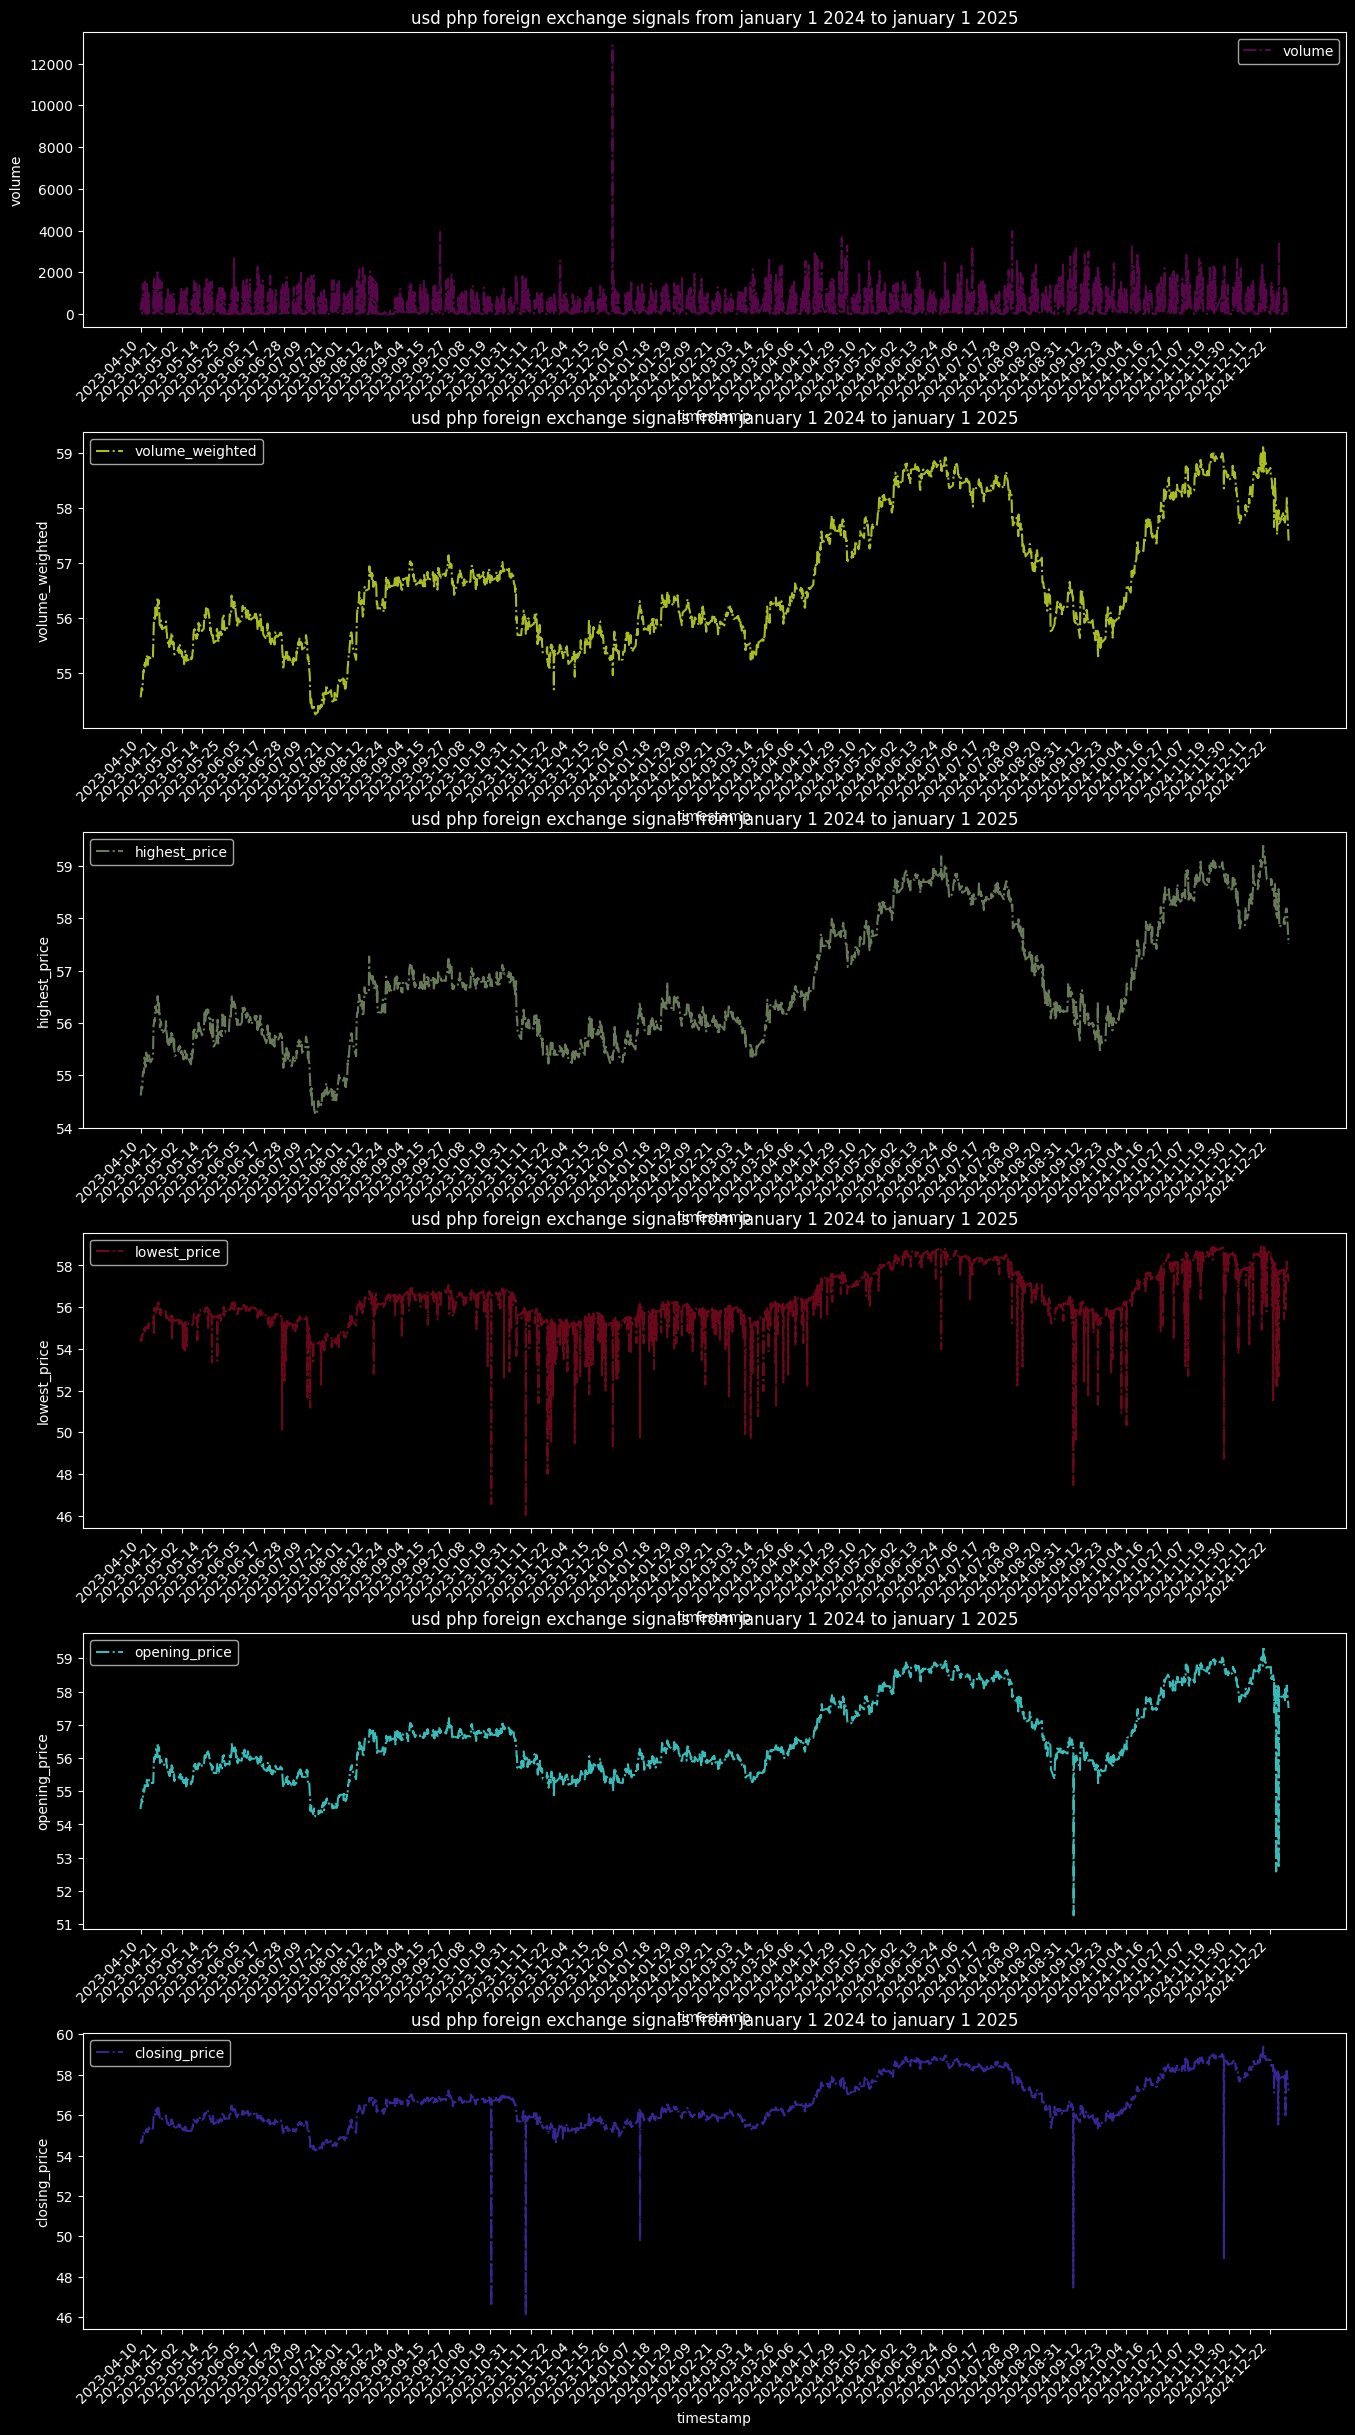

In [49]:
plot_forex_signals(usd_php_forex_4hour_df, img_title=f"usd php foreign exchange signals from {start_date} to {end_date}")

# Exploratory data analysis of forex signals

# Preparing data for forecasting

#### Recall that in eda signals there was only one column which was the raw eda signal column we then windowed this column to then have a resultant data with dimensions `(m, window_size, 1)`

In [50]:
# let's say we our raw eda signals were sampled at 128hz (128 samples per second)
hertz = 128
sec_per_min = 60

# and we wanted this recording to be 5 minutes
minutes = 5
np.random.seed(42)

# since 128 is 1 second and 1 minute is 60 seconds and 60 minutes is 3600 seconds
# we'd have to multiply 128 by 3600 which is 
subject_1_raw_eda_signals = np.cumprod((np.random.randn(hertz * sec_per_min * minutes) / 100 + 0.001) + 1)
subject_1_raw_eda_signals

array([1.00596714e+00, 1.00558222e+00, 1.01310084e+00, ...,
       1.05100539e+15, 1.05330838e+15, 1.04822136e+15], shape=(38400,))

In [51]:
time = np.arange(subject_1_raw_eda_signals.shape[0])
time

array([    0,     1,     2, ..., 38397, 38398, 38399], shape=(38400,))

In [52]:
segment_start = 0
segment_end = -1

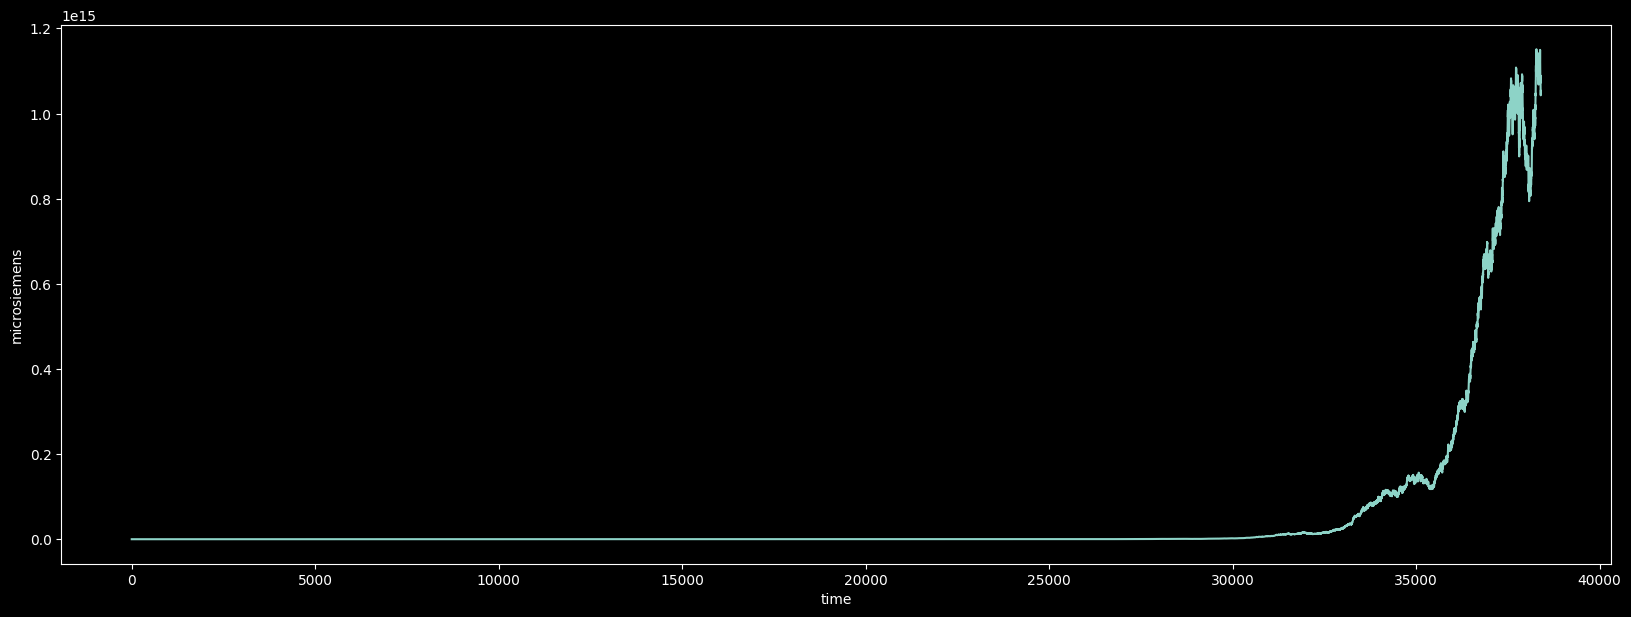

In [53]:
fig = plt.figure(figsize=(20, 7))
axis = fig.add_subplot()
axis.plot(time[segment_start:segment_end], subject_1_raw_eda_signals[segment_start:segment_end])
axis.set_ylabel('microsiemens')
axis.set_xlabel('time')
plt.show()

In [54]:
def charge_raw_data(datum: np.ndarray, hertz: int, window_time: int, hop_time: int):
    """
    convert audio signals of each subject into 3D matrices to be fed
    later to an LSTM model
    """

    # get number of rows of 16000hz signals 
    n_rows = datum.shape[0]
    x_signals = datum
    # print(n_rows)

    # we calculate the window size of each segment or the
    # amount of samples it has to have based on the frequency
    samples_per_win_size = int(window_time * hertz)
    samples_per_hop_size = int(hop_time * hertz)
    print(f"samples per window size: {samples_per_win_size}")
    print(f"samples per hop size: {samples_per_hop_size}\n")

    # initialize segments to empty list as this will store our
    # segmented signals 
    # subject_names = []
    segments = []
    
    # this segments our signals into overlapping segments
    for i in range(0, (n_rows - samples_per_win_size) + samples_per_hop_size, samples_per_hop_size):
        # # last segment would have start x: 464000 - end x: 512000
        # # and because 512000 plus our hop size of 16000 = 528000 
        # # already exceeding 521216 this then terminates the loop
        # i += samples_per_hop_size
        # start = i
        # end = i + samples_per_win_size
        start = i
        end = min((i + samples_per_win_size), n_rows)
        # print(f'start x: {start} - end x: {end}')

        # extract segment from calculated start and end
        # indeces
        segment = x_signals[start:end]
        if segment.shape[0] < samples_per_win_size:
            last_sample = segment[-1]

            # (n_padding_we_want_for_the_front_of_the_array, 
            # n_padding_we_want_for_the_back_of_the_array)
            # 
            n_pad_to_add = samples_per_win_size - segment.shape[0]
            print(f"n padding to be added: {n_pad_to_add}") 

            # we use the last value of the segment as padding to fill in
            # the empty spots
            segment = np.pad(segment, (0, n_pad_to_add), mode="constant", constant_values=last_sample)

        segments.append(segment)

    # because x_window_list and y_window_list when converted to a numpy array will
    # be of dimensions (m, 640) and (m,) respectively we need to first and foremost
    # reshpae x_window_list into a 3D matrix such that it is able to be taken in
    # by an LSTM layer, m being the number of examples, 640 being the number of time steps
    # and 1 being the number of features which will be just our raw audio signals.    
    X = np.array(segments)
    subject_signal = np.reshape(X, (X.shape[0], X.shape[1], -1))

    # Y = np.array(labels)
    # subject_labels = np.reshape(Y, (Y.shape[0], -1))

    return subject_signal

In [55]:
# having a window time of 0.25s will result in 32 samples
# per window since 0.25 * 128 is 32, likewise with
# hop time of 0.125 will result in 16 samples 
window_time = 0.25
hop_time = 0.125

# we have 5 minutes of recording per subject 
subject_signal = charge_raw_data(subject_1_raw_eda_signals, hertz=hertz, window_time=window_time, hop_time=hop_time)

samples per window size: 32
samples per hop size: 16



In [56]:
subject_signal.shape

(2399, 32, 1)

![title](./figures%20&%20images/multivariate-multistep%20forecasting.png)

Instead of one feature which came from our single column raw eda signal, we can consider multiple signals and use those as features in our input to a sequential model. So instead of a `(m, input_window_size, 1)` matrix of input training examples our training examples would now be `(m, input_window_size, n_f)`. In stock market analysis we can have the volume, volume_weighted, closing_price, opening_price, highest_price, and lowest_price as our features. Reference https://www.kaggle.com/code/ritesh7355/develop-lstm-models-for-time-series-forecasting

![image](./figures%20&%20images/Screenshot%202025-03-27%20125325.png)

In [57]:
# instead of we use multivariate dummy stock/forex market signals
# we use 4 hour interval for each day, since it takes 6 4hours to
# make 24 hours or 1 days, we would have 600 signals all in all
interval = 4
days = 100
length = (24 // interval) * days
print(length)

# and we wanted this recording to be 5 minutes
np.random.seed(42)

# since 128 is 1 second and 1 minute is 60 seconds and 60 minutes is 3600 seconds
# we'd have to multiply 128 by 3600 which is 
dum_forex_signals = np.cumprod((np.random.randn(length, 6) / 100 + 0.001) + 1, axis=1)
dum_forex_signals[:5]

600


array([[1.00596714, 1.00558222, 1.01310084, 1.02954377, 1.0281626 ,
        1.02678345],
       [1.01679213, 1.02561214, 1.02182276, 1.02838859, 1.02465124,
        1.02090379],
       [1.00341962, 0.98522481, 0.96921572, 0.96473516, 0.95592875,
        0.95988866],
       [0.99191976, 0.97890276, 0.99422894, 0.99297843, 0.99464195,
        0.98146545],
       [0.99555617, 0.99765603, 0.98717072, 0.99186668, 0.98690101,
        0.98500918]])

In [58]:
time = np.arange(dum_forex_signals.shape[0])
time

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

#### Imagine this would be our `volume`, `volume_weighted`, `close`, `high`, `low`, and `open price` features

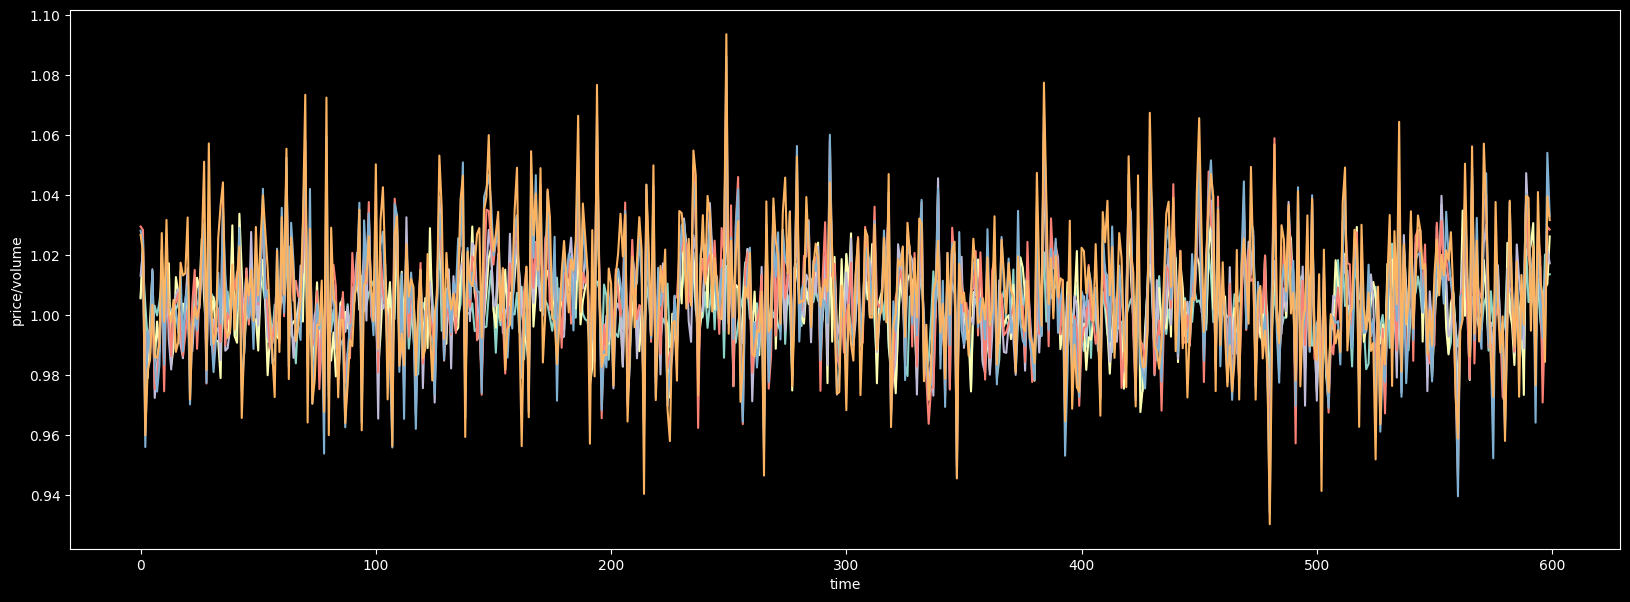

In [59]:
fig = plt.figure(figsize=(20, 7))
axis = fig.add_subplot()
for f_i in range(dum_forex_signals.shape[1]):

    axis.plot(time, dum_forex_signals[:, f_i])
    axis.set_ylabel('price/volume')
    axis.set_xlabel('time')
plt.show()

In [60]:
def charge_raw_data(datum: np.ndarray, input_window_size: int, target_window_size: int, hop_size: int):
    """
    convert audio signals of each subject into 3D matrices to be fed
    later to an LSTM model
    """

    # calculate the total window size thorugh input and target winodw sizes
    window_size = input_window_size + target_window_size

    # get number of rows of 16000hz signals 
    n_rows = datum.shape[0]
    x_signals = datum
    print(n_rows)


    # initialize segments to empty list as this will store our
    # segmented signals 
    # subject_names = []
    input_segments = []
    target_segments = []
    
    # this segments our signals into overlapping segments
    for i in range(0, (n_rows - window_size) + hop_size, hop_size):
        # # last segment would have start x: 464000 - end x: 512000
        # # and because 512000 plus our hop size of 16000 = 528000 
        # # already exceeding 521216 this then terminates the loop
        # i += hop_size
        # start = i
        # end = i + window_size
        start = i
        end = min((i + window_size), n_rows)
        # print(f'start x: {start} - end x: {end}')

        # extract segment from calculated start and end
        # indeces, which will be a (window_size, n_f matrix)
        segment = x_signals[start:end, :]
        
        if segment.shape[0] < window_size:
            print(f'last segment shape {segment.shape}')

            # we grab the last day close, high, open, low prices, and volume, and
            # volume weighted values
            last_sample = segment[-1, :]
            n_repeats = window_size - segment.shape[0]
            print(f"n padding to be added: {n_repeats}") 

            # we create the features for the missing days by replicating
            # the feature values of the last day in the segment
            # resulting in a (window_size - segment.shape[0], n_features)
            # matrix
            last_samples = np.repeat([last_sample], repeats=n_repeats)            
            

            # we use the newly created copy of the last day to fill in
            # the empty spots
            segment = np.concat((segment, last_samples), axis=0)

        # split the segment into the input and target segments
        input_segment = segment[:input_window_size, :]
        target_segment = segment[input_window_size:, :]
        # print(input_segment.shape)
        # print(target_segment.shape)

        # append input_segment and target_segment into their
        # respective input and target segments lists
        input_segments.append(input_segment)
        target_segments.append(target_segment)


    # because x_window_list and y_window_list when converted to a numpy array will
    # be of dimensions (m, 6) and (m, 4) respectively we need to first and foremost
    # reshpae x_window_list into a 3D matrix such that it is able to be taken in
    # by an LSTM layer, m being the number of examples, 640 being the number of time steps
    # and 1 being the number of features which will be just our raw audio signals.    
    inputs = np.array(input_segments)
    print(inputs.shape)

    targets = np.array(target_segments)
    print(targets.shape)

    return inputs, targets

In [61]:
# because there are 100 days each day having a 4 hour interval which would
# result in 6 signals per day of close, high, low, volume, volume_weighted, and open
# we can choose our window size to be 6, meaning we consider 6 4h intervals as our
# input signal
input_window_size = 6
# and then predict let's say the next 16 hours of a signal so we would have a
# target size of 4 since 16 hours is 4 4h intervals
target_window_size = 4

 
# we can consider our hop size to be 1 since each signal in the 4h interval 
# is important
hop_size = 1
inputs, targets = charge_raw_data(dum_forex_signals,
    input_window_size=input_window_size,
    target_window_size=target_window_size,
    hop_size=hop_size)

600
(591, 6, 6)
(591, 4, 6)


# the shapes when we preprocess our input and outputs will be $(m, input\_window\_size, n_f)$ and $(m, target\_window\_size, n_f)$. Now let's see if our windowing function works correctly by seeing the closing price feature only

In [62]:
window_size = input_window_size + target_window_size
window_size

10

In [63]:
# we get the frist five examples
# this is the first examples first feature in a period of 6 days
example_no = 0
for i, close_price in enumerate(inputs[example_no, :, 0]):
    print(f"day {(i + 1) + example_no} close_price: {close_price}")

day 1 close_price: 1.0059671415301124
day 2 close_price: 1.0167921281550738
day 3 close_price: 1.0034196227156604
day 4 close_price: 0.9919197592447879
day 5 close_price: 0.9955561727547482
day 6 close_price: 0.994982933877706


In [64]:
# we get the frist five examples
# this is the first examples first feature in a period of 6 days
example_no = 1
for i, close_price in enumerate(inputs[example_no, :, 0]):
    print(f"day {(i + 1) + example_no} close_price: {close_price}")

day 2 close_price: 1.0167921281550738
day 3 close_price: 1.0034196227156604
day 4 close_price: 0.9919197592447879
day 5 close_price: 0.9955561727547482
day 6 close_price: 0.994982933877706
day 7 close_price: 1.0030886359500475


# we can check if our windowing function works correctly by seeing now our target window values

In [65]:
# we get the frist five examples
# this is the first examples first feature in a period of 6 days
example_no = 0
for i, close_price in enumerate(targets[example_no, :, 0]):
    print(f"day {(i + 1) + example_no} close_price: {close_price}")

day 1 close_price: 1.0030886359500475
day 2 close_price: 0.9998435171761176
day 3 close_price: 1.0044361828956847
day 4 close_price: 1.0113099952249596


In [66]:
# we get the frist five examples
# this is the first examples first feature in a period of 6 days
example_no = 1
for i, close_price in enumerate(targets[example_no, :, 0]):
    print(f"day {(i + 1) + example_no} close_price: {close_price}")

day 2 close_price: 0.9998435171761176
day 3 close_price: 1.0044361828956847
day 4 close_price: 1.0113099952249596
day 5 close_price: 0.9962082576215471


In [67]:
# y-axis values

# (1, 6, 1) is the dimension of a single examples inputs closing price across 6 days
close_price_input_1 = inputs[0, :, 0]
# (1, 4, 1) is the dimension of a single examples targets closing price across 4 days
close_price_target_1 = targets[0, :, 0]
close_price_segment_1 = np.concat((close_price_input_1, close_price_target_1)) 

# x-axis values
time_input_1 = np.linspace(0, input_window_size - 1, num=close_price_input_1.shape[0])
time_target_1 = np.linspace(input_window_size, window_size - 1, close_price_target_1.shape[0])


In [68]:
close_price_input_1

array([1.00596714, 1.01679213, 1.00341962, 0.99191976, 0.99555617,
       0.99498293])

In [69]:
close_price_target_1

array([1.00308864, 0.99984352, 1.00443618, 1.01131   ])

In [70]:
time_input_1.shape

(6,)

In [71]:
time_target_1.shape

(4,)

#### append extra last value of `input_window` to the front of `target_window` so that when plotted the lines are connected

In [72]:
close_price_target_1 = np.concat((np.array([close_price_input_1[-1]]), close_price_target_1), axis=0)
time_target_1 = np.concat((np.array([time_input_1[-1]]), time_target_1), axis=0)

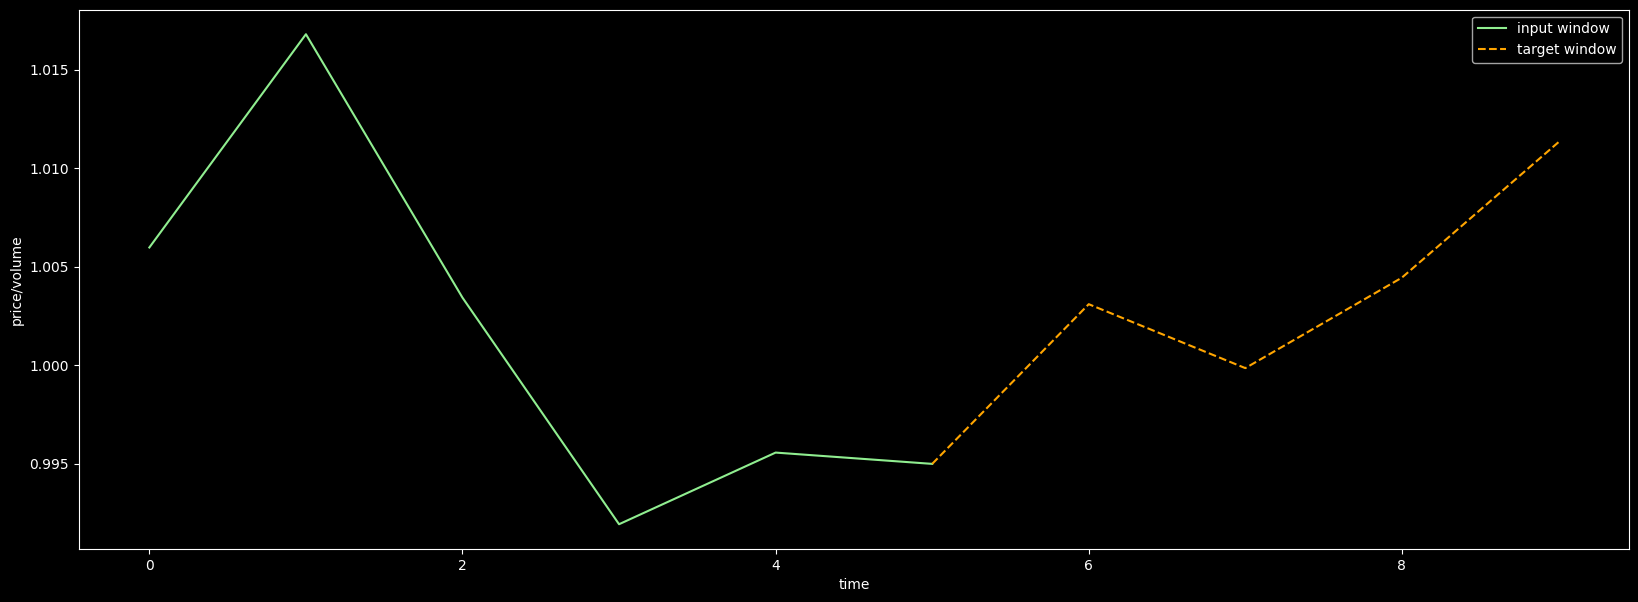

In [73]:
fig = plt.figure(figsize=(20, 7))
axis = fig.add_subplot()
axis.plot(time_input_1, close_price_input_1, color="lightgreen", label="input window")
axis.plot(time_target_1, close_price_target_1, color="orange", label="target window", linestyle="--")
axis.set_ylabel('price/volume')
axis.set_xlabel('time')
axis.legend()
plt.show()

# Modelling

In [74]:
usd_php_forex_4hour_df

,volume,volume_weighted,opening_price,closing_price,highest_price,lowest_price,timestamp,transactions
0,183,54.5591,54.464,54.577,54.616,54.464,2023-04-10 08:00:00,183
1,431,54.5877,54.576,54.618,54.641,54.390,2023-04-10 12:00:00,431
2,538,54.6423,54.616,54.663,54.687,54.471,2023-04-10 16:00:00,538
3,498,54.6885,54.643,54.754,54.787,54.390,2023-04-10 20:00:00,498
4,124,54.7292,54.764,54.690,54.777,54.666,2023-04-11 00:00:00,124
...,...,...,...,...,...,...,...,...
2791,785,57.9079,57.996,57.868,58.163,56.303,2024-12-31 16:00:00,785
2792,1106,57.9427,57.858,57.782,58.123,57.745,2024-12-31 20:00:00,1106
2793,1156,57.9018,57.782,58.181,58.181,57.774,2025-01-01 00:00:00,1156
2794,1,58.1810,58.181,58.181,58.181,58.181,2025-01-01 04:00:00,1


In [76]:
forex_signals = usd_php_forex_4hour_df[["volume", "volume_weighted", "opening_price", "closing_price", "highest_price", "lowest_price"]]
forex_signals

,volume,volume_weighted,opening_price,closing_price,highest_price,lowest_price
0,183,54.5591,54.464,54.577,54.616,54.464
1,431,54.5877,54.576,54.618,54.641,54.390
2,538,54.6423,54.616,54.663,54.687,54.471
3,498,54.6885,54.643,54.754,54.787,54.390
4,124,54.7292,54.764,54.690,54.777,54.666
...,...,...,...,...,...,...
2791,785,57.9079,57.996,57.868,58.163,56.303
2792,1106,57.9427,57.858,57.782,58.123,57.745
2793,1156,57.9018,57.782,58.181,58.181,57.774
2794,1,58.1810,58.181,58.181,58.181,58.181


In [78]:
# because there are 100 days each day having a 4 hour interval which would
# result in 6 signals per day of close, high, low, volume, volume_weighted, and open
# we can choose our window size to be 6, meaning we consider 6 4h intervals as our
# input signal
input_window_size = 6
# and then predict let's say the next 16 hours of a signal so we would have a
# target size of 4 since 16 hours is 4 4h intervals
target_window_size = 4

 
# we can consider our hop size to be 1 since each signal in the 4h interval 
# is important
hop_size = 1
inputs, targets = charge_raw_data(forex_signals.to_numpy(),
    input_window_size=input_window_size,
    target_window_size=target_window_size,
    hop_size=hop_size)

2796
(2787, 6, 6)
(2787, 4, 6)


In [96]:
inputs[:5]

array([[[ 183.    ,   54.5591,   54.464 ,   54.577 ,   54.616 ,
           54.464 ],
        [ 431.    ,   54.5877,   54.576 ,   54.618 ,   54.641 ,
           54.39  ],
        [ 538.    ,   54.6423,   54.616 ,   54.663 ,   54.687 ,
           54.471 ],
        [ 498.    ,   54.6885,   54.643 ,   54.754 ,   54.787 ,
           54.39  ],
        [ 124.    ,   54.7292,   54.764 ,   54.69  ,   54.777 ,
           54.666 ],
        [  17.    ,   54.6901,   54.703 ,   54.738 ,   54.754 ,
           54.673 ]],

       [[ 431.    ,   54.5877,   54.576 ,   54.618 ,   54.641 ,
           54.39  ],
        [ 538.    ,   54.6423,   54.616 ,   54.663 ,   54.687 ,
           54.471 ],
        [ 498.    ,   54.6885,   54.643 ,   54.754 ,   54.787 ,
           54.39  ],
        [ 124.    ,   54.7292,   54.764 ,   54.69  ,   54.777 ,
           54.666 ],
        [  17.    ,   54.6901,   54.703 ,   54.738 ,   54.754 ,
           54.673 ],
        [ 769.    ,   54.6996,   54.695 ,   54.692 ,   54.758 ,

In [95]:
inputs.shape

(2787, 6, 6)

In [80]:
import torch
from torch import nn

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_f: int, n_a: int, *args, **kwargs):
        """
        n_f is the number of features of the signal data, n_a 
        is the numbeer of nodes to be used by the LSTM and is
        also the number of features/nodes by the hidden/cell
        state
        """
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(input_size=n_f, hidden_size=n_a, num_layers=1, batch_first=True)

    def forward(self, inputs):
        outputs, hidden = self.lstm(inputs)

        return outputs, hidden

In [92]:
enc_hyper_params = {"n_f": 6, "n_a": 32}
enc = Encoder(**enc_hyper_params)

In [153]:
torch_inputs = torch.from_numpy(inputs).to(torch.float32)
torch_targets = torch.from_numpy(targets).to(torch.float32)
torch_inputs.shape, torch_targets.shape

(torch.Size([2787, 6, 6]), torch.Size([2787, 4, 6]))

In [ ]:
enc_outs, [h, c] = enc(torch_inputs)

#### `outputs` is the hidden states of the LSTM at all timesteps which is of shape $(m, T_x, n_a)$

In [ ]:
enc_outs.shape

torch.Size([2787, 6, 32])

#### h and c are the hidden and cell states at the last timestep of the LSTM which is of shape $(1, m, n_a)$  where 1 is the a timestep of an LSTM which is again the last cell of an LSTM/RNN 

In [123]:
h.shape

torch.Size([1, 2787, 32])

In [124]:
c.shape

torch.Size([1, 2787, 32])

#### next is we build a decoder like this

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_f: int, n_a: int, target_n_f: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # we would want to input the close, open, high, low, volume, and volume_weighted
        # values as features to the lstm at each timestep
        self.lstm = nn.LSTM(input_size=n_f, hidden_size=n_a, batch_first=True, num_layers=1)
        
        # we would also want to output the same amount of features for
        # the dense layers as we did earlier in our input for our LSTM
        self.dense = nn.Linear(in_features=n_a, out_features=target_n_f)
        
    def forward(self, init_dec_input, context_vec, target_windows, teacher_force_prob):
        """
        we need the our target windows passed also to forward
        as we will be using it as input to the decoder

        we also need the last hidden state as context vector to
        the lstm

        and we need the input at the last timestep of the encoder
        as input again to the decoder as these simulates prediction
        of the next close, open, low, high, volume, and volume_weighted
        feature for the next days
        """

        # get the number of timesteps or the window size of 
        # the target windows variable containing our targets
        # the model needs to learn to forecast
        T_y = target_windows.shape[1]
        outputs = []

        # set the input at timestep t intially to the decoder input
        # which is the input of the encoder at its last timestep
        input_at_t = init_dec_input.unsqueeze(1)
        print(input_at_t.shape)

        # context vec is a list containing the encoders
        # hidden state and cell state at the last timestep
        h, c = context_vec
        for t in range(T_y):
            # get the hidden state at this time step which would
            # be of shape (m, 1, n_a)
            dec_outs, [h, c] = self.lstm(input_at_t, [h, c])
            # print(dec_outs.shape)

            dense_outs = self.dense(dec_outs)
            outputs.append(dense_outs)

            # we use either the target output at timestep t or the
            # predicted outuput from the dense layer at timestep t
            # this is what we call teacher forcing
            input_at_t = target_windows[:, t, :].unsqueeze(1) if torch.rand(1) < teacher_force_prob else dense_outs

        print(len(outputs))


In [180]:
dec_hyper_params = {"n_f": 6, "n_a": 32, "target_n_f": targets.shape[2]}
dec = Decoder(**dec_hyper_params)

In [181]:
init_dec_input = torch_inputs[:, -1, :]
context_vec = [h, c]
teacher_force_prob = 0.7

In [182]:
dec(init_dec_input, context_vec, torch_targets, teacher_force_prob)

torch.Size([2787, 1, 6])
4


In [ ]:
torch.tensor([])